In [24]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import math as m
import numpy as np
import os
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import sys
sns.set()

In [25]:
def growth_rate_to_doubling_time(growth_rates):
    return np.sign(growth_rates) * (np.log(2) / (np.sign(growth_rates) * growth_rates))

def doubling_time_to_growth_rate(doubling_times):
    return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))

In [2]:
data = pd.read_excel("../../Data/Simulation Results/growth rates no test delays.xlsx", index_col = 0)
days_simulated = 25

In [3]:
data

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,two_step_tracing,prob_has_trace_app,0,1,2,...,15,16,17,18,19,20,21,22,23,24
0,0.236797,0.4,0.936054,1.960695,0.752697,False,0.296060,5000,5009,5128,...,15887,16467,16977,17463,17869,18271,18603,18887,19167,19431
1,0.215233,0.1,0.714895,2.495259,0.708004,False,0.304609,5000,5004,5140,...,20123,21405,22706,24010,25259,26564,27823,29106,30417,31636
2,0.222421,0.2,0.722980,1.925419,0.279539,False,0.314651,5000,5017,5269,...,64454,74839,86533,99747,114749,131399,150096,171286,194780,220918
3,0.243986,0.5,0.908680,2.396449,0.261598,False,0.102020,5000,5015,5308,...,60464,68713,77553,87101,97222,107991,119493,131863,144979,158934
4,0.215233,0.1,0.812495,2.015778,0.814892,True,0.390956,5000,5004,5124,...,14450,14989,15494,15990,16431,16876,17296,17692,18038,18383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.215233,0.1,0.728916,1.654944,0.810166,True,0.182085,5000,5006,5119,...,14478,15012,15552,16006,16455,16916,17335,17738,18103,18445
96,0.243986,0.5,0.780553,1.649653,0.758406,True,0.359491,5000,5007,5139,...,15681,16177,16614,17025,17375,17688,17951,18205,18403,18597
97,0.215233,0.1,0.858752,1.870648,0.872757,False,0.410021,5000,5006,5103,...,11976,12249,12468,12712,12961,13139,13313,13466,13594,13737
98,0.236797,0.4,0.805977,2.276062,0.182954,False,0.049370,5000,5013,5319,...,77222,90311,104880,121383,140317,161426,184921,211679,241116,274661


In [4]:
infection_counts = [str(i) for i in range(days_simulated)]
infection_counts = data[infection_counts]

Text(0.5, 1.0, 'Total Infected')

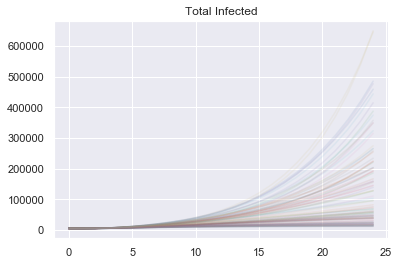

In [5]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_], alpha = 0.1)
plt.title("Total Infected")

Text(0.5, 1.0, '$log_2$(Total Infected)')

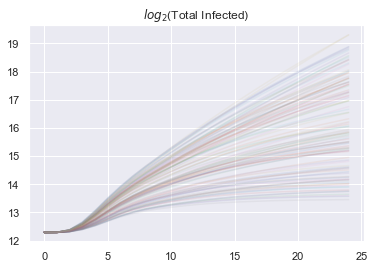

In [6]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].apply(lambda x: np.log2(x)), alpha = 0.1)
plt.title("$log_2$(Total Infected)")

Text(0.5, 1.0, 'Infection Incidence')

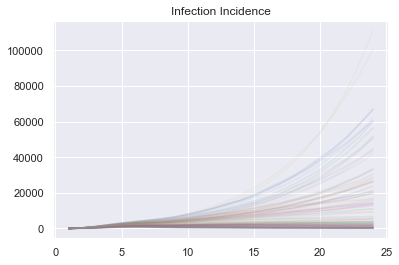

In [7]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.1)
plt.title("Infection Incidence")

Text(0.5, 1.0, 'Infection Incidence (10 epidemics)')

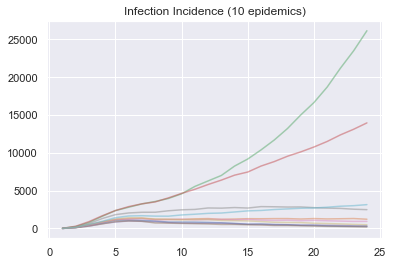

In [8]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.5)
plt.title("Infection Incidence (10 epidemics)")

Text(0.5, 1.0, '$Log_e$(Case Incidence) (14 epidemics)')

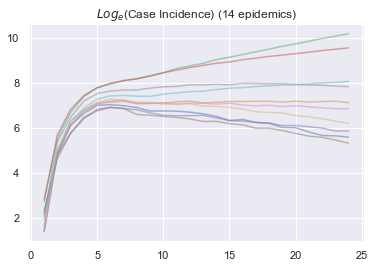

In [10]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x)), alpha = 0.5)
plt.title("$Log_e$(Case Incidence) (14 epidemics)")

We can see the variance begins to increase for the exponentially decaying epidemcis as they near 0. In order to get good estimation for the epidemics, we icnrease the starting number of infections. In this experiment, we start with 5000 infected, let the process run for 10 days, and then estimated the growth rate using days 10-30.

In [11]:
log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

data_set_up = {
    "log_case_incidence": log_diff[10:days_simulated],
    "time": list(range(10, days_simulated))
}
dataframe = pd.DataFrame(data_set_up)

                            OLS Regression Results                            
Dep. Variable:     log_case_incidence   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     943.1
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           1.61e-13
Time:                        20:22:46   Log-Likelihood:                 37.411
No. Observations:                  15   AIC:                            -70.82
Df Residuals:                      13   BIC:                            -69.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1250      0.022    316.694      0.0

C:\Users\mfyles\OneDrive - The Alan Turing Institute\Documents\GitHub\household-contact-tracing\env\lib\site-packages\scipy\stats\stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


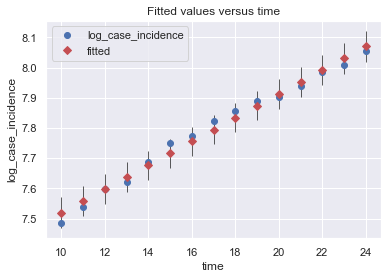

In [12]:
y, X = dmatrices('log_case_incidence ~ time', 
                 data = dataframe)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig = sm.graphics.regressionplots.plot_fit(res, 1)
print(f"doublign time = {m.log(2)/res.params[1]}")

In [13]:
data_subset = infection_counts

In [26]:
growth_rates = []
for _ in range(data_subset.shape[0]):
    print(f"current fit; {_}", end = "\r")
    
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    data_set_up = {
        "log_case_incidence": log_diff[10:25],
        "time": list(range(10, 25))
    }
    dataframe = pd.DataFrame(data_set_up)
    dataframe = pd.DataFrame(data_set_up)
    
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

In [27]:
x = pd.Series(growth_rates) # 200 values
#x = x[x.between(x.quantile(.05), x.quantile(.95))] # without outliers

Text(0.5, 1.0, 'Distribution of Growth Rates')

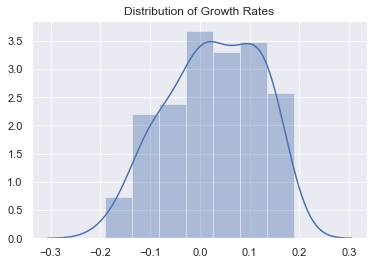

In [28]:
sns.distplot(x)
plt.title("Distribution of Growth Rates")

In [29]:
data_pars = data[data.columns[0:7]]
growth_rate_series = pd.Series(growth_rates)
data_pars["growth_rate"] = growth_rate_series

<ipython-input-29-3dee0425568c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pars["growth_rate"] = growth_rate_series


In [30]:
data_pars

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,two_step_tracing,prob_has_trace_app,growth_rate
0,0.236797,0.4,0.936054,1.960695,0.752697,False,0.296060,-0.091171
1,0.215233,0.1,0.714895,2.495259,0.708004,False,0.304609,0.001975
2,0.222421,0.2,0.722980,1.925419,0.279539,False,0.314651,0.120811
3,0.243986,0.5,0.908680,2.396449,0.261598,False,0.102020,0.076011
4,0.215233,0.1,0.812495,2.015778,0.814892,True,0.390956,-0.054119
...,...,...,...,...,...,...,...,...
95,0.215233,0.1,0.728916,1.654944,0.810166,True,0.182085,-0.052599
96,0.243986,0.5,0.780553,1.649653,0.758406,True,0.359491,-0.108724
97,0.215233,0.1,0.858752,1.870648,0.872757,False,0.410021,-0.099269
98,0.236797,0.4,0.805977,2.276062,0.182954,False,0.049370,0.124340


                            OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1893.
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           1.75e-96
Time:                        20:27:40   Log-Likelihood:                 346.99
No. Observations:                 100   AIC:                            -678.0
Df Residuals:                      92   BIC:                            -657.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

<ipython-input-25-e3933c76672f>:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))
<ipython-input-25-e3933c76672f>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))
<ipython-input-25-e3933c76672f>:2: RuntimeWarning: invalid value encountered in sign
  return np.sign(growth_rates) * (np.log(2) / (np.sign(growth_rates) * growth_rates))


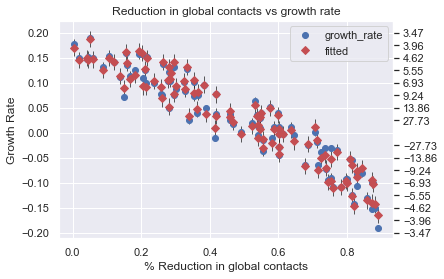

In [41]:
y, X = dmatrices('growth_rate ~ global_contact_reduction + I(global_contact_reduction**2) + I(prob_has_trace_app**2) + contact_tracing_success_prob + contact_trace_delay_par + contact_trace_delay_par + infection_reporting_prob + two_step_tracing', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

fig, ax = plt.subplots()

sm.graphics.regressionplots.plot_fit(res, "global_contact_reduction", ax = ax)

y_vals = np.linspace(-0.20, 0.25, 19)
y_vals = np.concatenate((y_vals[:8], y_vals[9:]))

ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.xlabel("% Reduction in global contacts")
plt.ylabel("Growth Rate")
plt.title("Reduction in global contacts vs growth rate")
plt.savefig("../../Figures/Simulation - no test delay/growth_rate_global_contacts.png")
plt.savefig("../../Figures/Simulation - no test delay/growth_rate_global_contacts.svg")

## Residuals vs Fitted Value

There doesn't appear to be any systematic deviation from our predicted value

Text(0, 0.5, 'Residual')

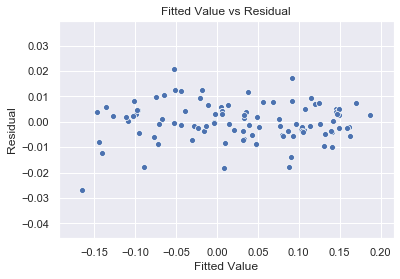

In [42]:
sns.scatterplot(res.fittedvalues, res.resid)
plt.title("Fitted Value vs Residual")
plt.xlabel("Fitted Value")
plt.ylabel("Residual")

## Residual Distribution

Text(0.5, 1.0, 'Distribution of the residuals')

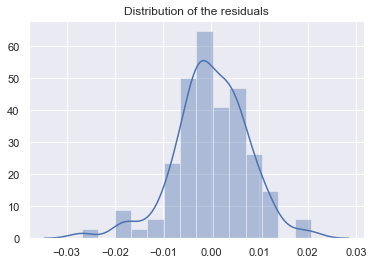

In [43]:
sns.distplot(res.resid)
plt.title("Distribution of the residuals")

Sort of normally distributed

## Normality of residuals tests

In [44]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(res.resid)
lzip(name, test)

[('Jarque-Bera', 10.504927316822267),
 ('Chi^2 two-tail prob.', 0.005234606218471965),
 ('Skew', -0.4225539806718826),
 ('Kurtosis', 4.3442377355626975)]

## Heteroskedasticity tests

We have strong heteroscedasticity in our data

In [45]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 10.765587815103196),
 ('p-value', 0.14917583732437983),
 ('f-value', 1.5856055892385048),
 ('f p-value', 0.14948637074959362)]

## Comparison to reference distributions

In [48]:
reference_coefs = pd.read_excel("../../Data/Reference/OLS_coefficients.xlsx", index_col = 0)
reference_coefs

,intercept,coef_contact_reduction,coef_contact_reduction**2,coef_contact_reduction**2.1
0,0.22251,-0.255676,0.123382,-0.286964


In [51]:
c = reference_coefs["intercept"].loc[0]
beta_0 = reference_coefs["coef_contact_reduction"].loc[0]
beta_1 = reference_coefs["coef_contact_reduction**2"].loc[0]
beta_2 = reference_coefs["coef_contact_reduction**2.1"].loc[0]
x = np.linspace(0, 0.9)
y = c + beta_0*x + beta_1*x**2 + beta_2*x**3

Text(0.5, 0, '% reduction in global contacts')

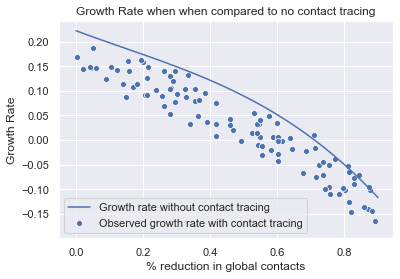

In [53]:
sns.scatterplot(data_pars["global_contact_reduction"], res.fittedvalues)
plt.plot(x, y)
plt.legend(("Growth rate without contact tracing", "Observed growth rate with contact tracing"))
plt.title("Growth Rate when when compared to no contact tracing")
plt.ylabel("Growth Rate")
plt.xlabel("% reduction in global contacts")
#plt.savefig("Figures/Simulation - no test delay/growth_rate_comparison.svg")